In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt


In [14]:
df = pd.read_csv("../data/processed/marketing_campaign_processed.csv")

In [15]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Age,FamilySize,TotalSpending,TotalAcceptedCmp,CampaignSuccessRate,IsParent,CustomerTenure,Churn
0,Graduation,Single,58138.0,0,0,635,88,546,172,88,...,0,1,68,2,1617,1,0.166667,0,663,0
1,Graduation,Single,46344.0,1,1,11,1,6,2,1,...,0,0,71,4,27,0,0.000000,1,113,0
2,Graduation,Together,71613.0,0,0,426,49,127,111,21,...,0,0,60,2,776,0,0.000000,0,312,0
3,Graduation,Together,26646.0,1,0,11,4,20,10,3,...,0,0,41,3,53,0,0.000000,1,139,0
4,PhD,Married,58293.0,1,0,173,43,118,46,27,...,0,0,44,3,422,0,0.000000,1,161,1


In [16]:
education_order = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

df['Education'] = df['Education'].map(education_order)
df['Education'].unique()


array([3, 5, 4, 1, 2])

In [17]:
# Hedef değişken
y = df['Churn']

# Özellikler
X = df.drop(columns=['Churn'])
X.shape, y.shape


((2240, 30), (2240,))

In [18]:
X_encoded = pd.get_dummies(X, columns=["Marital_Status"], drop_first=True)

X_encoded.head()


,Education,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,CampaignSuccessRate,IsParent,CustomerTenure,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,3,58138.0,0,0,635,88,546,172,88,88,...,0.166667,0,663,False,False,False,True,False,False,False
1,3,46344.0,1,1,11,1,6,2,1,6,...,0.000000,1,113,False,False,False,True,False,False,False
2,3,71613.0,0,0,426,49,127,111,21,42,...,0.000000,0,312,False,False,False,False,True,False,False
3,3,26646.0,1,0,11,4,20,10,3,5,...,0.000000,1,139,False,False,False,False,True,False,False
4,5,58293.0,1,0,173,43,118,46,27,15,...,0.000000,1,161,False,False,True,False,False,False,False


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((1792, 36), (448, 36))

In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


In [21]:
rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)


In [22]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [23]:
grid_search.best_params_


{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [24]:
grid_search.best_score_


np.float64(0.6395739276804555)

In [25]:
best_rf = grid_search.best_estimator_

best_rf.fit(X_train, y_train)

y_pred_best = best_rf.predict(X_test)
y_pred_best_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_best_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Accuracy: 0.6428571428571429
F1 Score: 0.36507936507936506
ROC-AUC: 0.6192703067071115

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.88      0.75       276
           1       0.57      0.27      0.37       172

    accuracy                           0.64       448
   macro avg       0.62      0.57      0.56       448
weighted avg       0.63      0.64      0.60       448



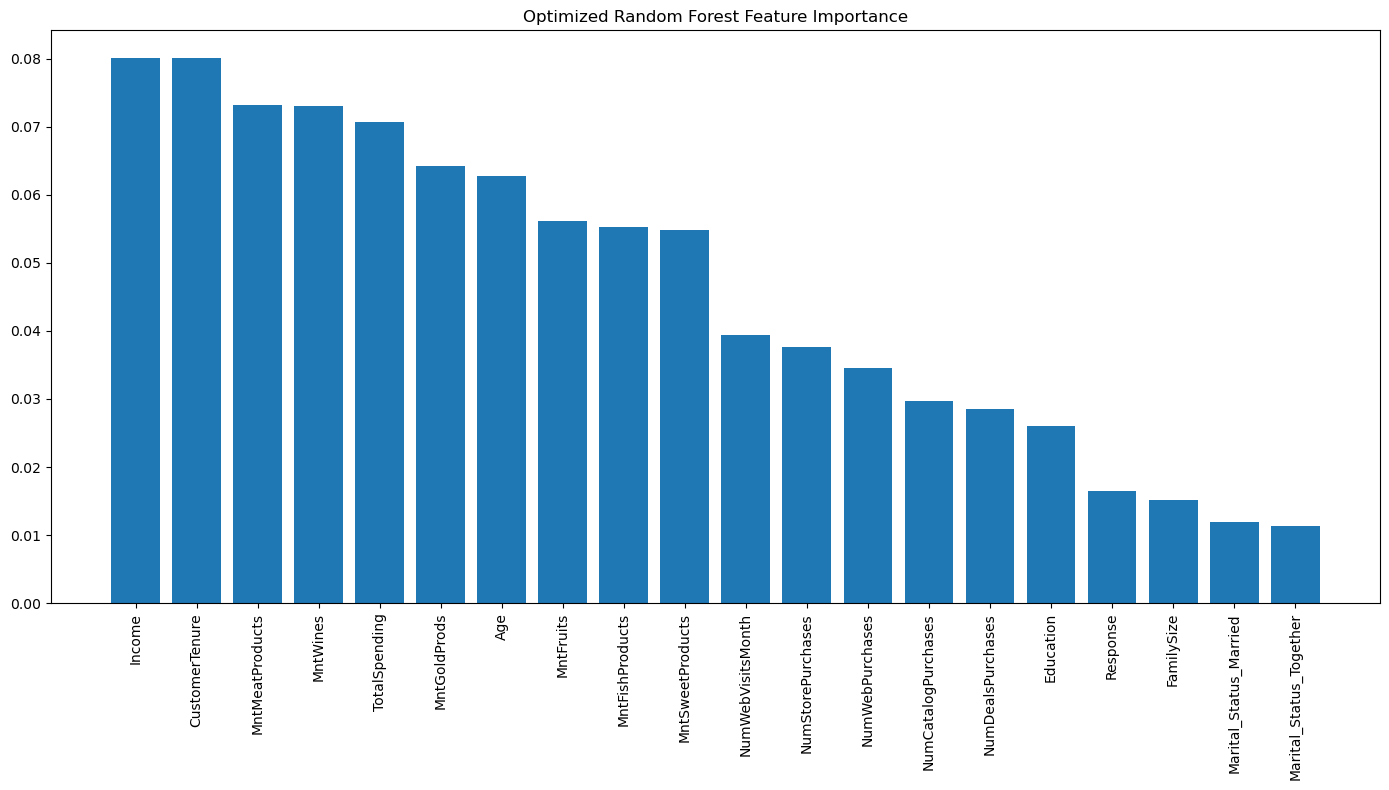

In [26]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_encoded.columns

plt.figure(figsize=(14, 8))
plt.title("Optimized Random Forest Feature Importance")
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), feature_names[indices][:20], rotation=90)
plt.tight_layout()
plt.show()
